In [13]:
import pytorch3d
import torch
from pytorch3d.renderer import compositing as compositing
from pytorch3d.renderer.points import rasterize_points
from torch import nn as nn
import numpy as np

@torch.jit.script
def linear_alpha(dist_xy, radius: float):
    dists2 = dist_xy.permute(0, 3, 1, 2)
    dists_norm = dists2 / (radius * radius)
    alpha = 1 - dists_norm
    return alpha


@torch.jit.script
def exponential_alpha(dist_xy, radius: float):
    dists2 = dist_xy.permute(0, 3, 1, 2)
    dists_norm = dists2 / (radius * radius)
    dists_norm = dists_norm.clamp(min=0.0)
    alpha = torch.exp(-1 * dists_norm)
    return alpha

def bp():
    import pdb;pdb.set_trace()

class PointsRenderer(nn.Module):
    """
    Adapted from PyTorch3D's PointRenderer. A class for rendering a batch of points.
    The class combines rasterization, weight calculation, and compisiting
    """

    def __init__(self, render_cfg):
        super().__init__()

        # Rasterizing settings
        self.S = render_cfg.render_size
        self.K = render_cfg.points_per_pixel

        # Convert radius from pixels to NDC
        radius = render_cfg.radius
        self.r = 2 * radius / float(render_cfg.render_size)

        # Define weight computation
        if render_cfg.weight_calculation == "linear":
            self.calculate_weights = linear_alpha
        elif render_cfg.weight_calculation == "exponential":
            self.calculate_weights = exponential_alpha
        else:
            raise ValueError()

        # Define compositing
        if render_cfg.compositor == "alpha":
            self.compositor = compositing.alpha_composite
        elif render_cfg.compositor == "weighted_sum":
            self.compositor = compositing.weighted_sum
        elif render_cfg.compositor == "norm_weighted_sum":
            self.compositor = compositing.norm_weighted_sum
        else:
            raise ValueError()

    def forward(self, points, features) -> torch.Tensor:
        """
            points      FloatTensor     B x N x 3
            features    FloatTensor     B x N x F
        """
        # Rasterize points -- bins set heurisically
        pointcloud = pytorch3d.structures.Pointclouds(points, features=features)
        idx, zbuf, dist_xy = rasterize_points(pointcloud, self.S, self.r, self.K)

        # Calculate PC coverage
        valid_pts = (idx >= 0).float()
        valid_ray = valid_pts[:, :, :, 0]

        # Calculate composite weights -- dist_xy is squared distance!!
        # Clamp weights to avoid 0 gradients or errors
        weights = self.calculate_weights(dist_xy, self.r)
        weights = weights.clamp(min=0.0, max=0.99)

        # Composite the raster for feats and depth
        idx = idx.long().permute(0, 3, 1, 2).contiguous()
        feats = pointcloud.features_packed().permute(1, 0)
        feats = self.compositor(idx, weights, feats)

        # == Rasterize depth ==
        # zero out weights -- currently applies norm_weighted sum
        w_normed = weights * (idx >= 0).float()
        w_normed = w_normed / w_normed.sum(dim=1, keepdim=True).clamp(min=1e-9)
        z_weighted = zbuf.permute(0, 3, 1, 2).contiguous() * w_normed.contiguous()
        z_weighted = z_weighted.sum(dim=1, keepdim=True)

        return {
            "raster_output": {
                "idx": idx,
                "zbuf": zbuf,
                "dist_xy": dist_xy,
                "alphas": weights,
                "points": points,
                "feats": features,
            },
            "feats": feats,
            "depth": z_weighted,
            "mask": valid_ray,
            "valid_rays": valid_ray.mean(dim=(1, 2)),
            "valid_pts": valid_pts.mean(dim=(1, 2, 3)),
        }

class render_setting(object):
    def __init__(self):
        self.render_size = 128
        self.pointcloud_source = "other"
        self.radius = 2.0
        self.points_per_pixel = 16
        self.compositor = "norm_weighted_sum"
        self.weight_calculation = "exponential"

In [14]:
import _init_paths
from dataset.modelnet40new_render import backproject
import hydra
import random
import os
import glob
import scipy.io as sio
import torch
import pickle
import cv2
import torch.utils.data as data
from os.path import join as pjoin
import matplotlib.pyplot as plt

In [15]:
def get_index(src_length, tgt_length):
    idx = np.arange(0, src_length)
    if src_length < tgt_length:
        idx = np.pad(idx, (0, tgt_length - src_length), 'wrap')
    idx = np.random.permutation(idx)[:tgt_length]
    return idx


def get_modelnet40_data(gt_path, meta, num_points):   # root_dset/render/airplane/train/0001/gt/001.npy
    """
    cloud_path = gt_path.replace('gt', 'cloud').replace('.npy', '.npz')   # precomputed partial cloud
    if os.path.exists(cloud_path):
        pts = np.load(cloud_path)['points']
    else:
    """
    depth_path = gt_path.replace('gt', 'depth').replace('.npy', '.png')
    depth = cv2.imread(depth_path, -1)
    pts = backproject(depth, meta['projection'], meta['near'], meta['far'],
                      from_image=True, vis=False)
    idx = get_index(len(pts), num_points)
    pts = pts[idx]
    gt_pose = np.load(gt_path)  # 4x4 matrix
    return pts, gt_pose

In [16]:
# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.transforms import Transform3d
from pytorch3d.transforms.rotation_conversions import random_rotations
from pytorch3d.transforms.so3 import so3_exponential_map
from pytorch3d.renderer.cameras import (
    CamerasBase,
    FoVOrthographicCameras,
    FoVPerspectiveCameras,
    OpenGLOrthographicCameras,
    OpenGLPerspectiveCameras,
    OrthographicCameras,
    PerspectiveCameras,
    SfMOrthographicCameras,
    SfMPerspectiveCameras,
    camera_position_from_spherical_angles,
    get_world_to_view_transform,
    look_at_rotation,
    look_at_view_transform,
)

In [58]:
import pickle
from os.path import join as pjoin
dataset_path = '/groups/arcadm/xiaolong/modelnet40new/'
target_category = 'airplane'
mode = 'test'
render_path = pjoin(dataset_path, 'render', target_category, mode)
points_path = pjoin(dataset_path, 'points', target_category, mode)
with open(pjoin(render_path, 'meta.pkl'), 'rb') as f:
    meta_dict = pickle.load(f)  # near, far, projection

file_path = '/groups/arcadm/xiaolong/modelnet40new/render/airplane/test/0649/gt/046.npy'
cloud, gt_pose = get_modelnet40_data(file_path, meta_dict, 4096)
points_batch = [cloud, cloud]
points_tensor = torch.from_numpy(np.stack(points_batch, axis=0).astype(np.float32))
feats_tensor = torch.ones_like(points_tensor)
print(points_tensor.shape)


# create render 
render_cfg = render_setting()
depth_render = PointsRenderer(render_cfg)

# create camera 
# RT and P
far = 10.0
cam = FoVPerspectiveCameras(znear=0.1, zfar=far, fov=60.0, aspect_ratio=640/480)
# points_tensor[:, :, -1] = -points_tensor[:, :, -1]
new_points = cam.transform_points(points_tensor)

torch.Size([2, 4096, 3])


In [60]:
# check raw point cloud
point_cloud_batch = Pointclouds(points=points_tensor) # , features=[rgb, torch.zeros_like(rgb)]
fig3 = plot_batch_individually(
    point_cloud_batch, 
    ncols=2,
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    subplot_titles=["Pointcloud1", "Pointcloud2"], # this should have a title for each subplot, titles can be ""
    axis_args=AxisArgs(showgrid=True))
fig3.show()


In [61]:
# check NDC visualization
point_cloud_batch_ndc = Pointclouds(points=new_points) # , features=[rgb, torch.zeros_like(rgb)]
fig1 = plot_batch_individually(
    point_cloud_batch_ndc, 
    ncols=2,
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    subplot_titles=["Pointcloud1 NDC", "Pointcloud2 NDC"], # this should have a title for each subplot, titles can be ""
    axis_args=AxisArgs(showgrid=True))
fig1.show()

data_dict = depth_render(new_points, feats_tensor)

In [62]:
# new_points[:, :, -1] = -new_points[:, :, -1]
data_dict = depth_render(new_points, feats_tensor)

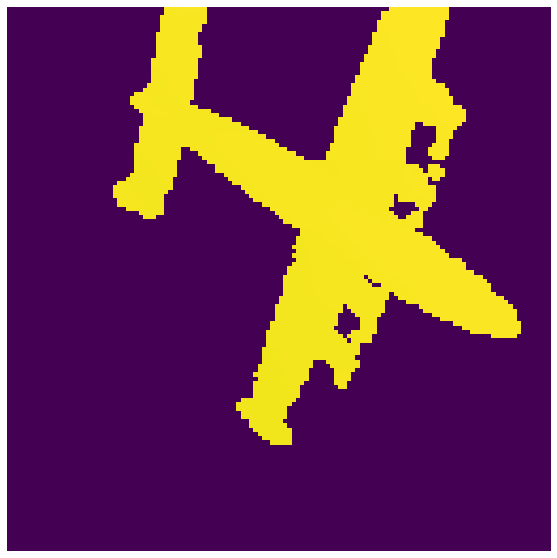

In [64]:
# check rendered depth data 
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(data_dict['depth'].squeeze().cpu().numpy()[0])
plt.grid("off");
plt.axis("off");


In [79]:
# check the closest K=3 points for visibility discovery
idx = data_dict['raster_output']['idx']
print(idx.shape)
visible_pts = idx[:, 0:3, :, :] # assume the 3 closest points are visible, may need tune point radius
visible_ids = visible_pts[visible_pts>0].unique()
print(visible_ids.shape)
visible_points = points_tensor.view(-1, 3).contiguous()
visible_points = visible_points[visible_ids.long()].unsqueeze(0).repeat(2, 1, 1).contiguous()
print(visible_points.shape)
point_cloud_batch_ndc = Pointclouds(points=visible_points) # , features=[rgb, torch.zeros_like(rgb)]
fig1 = plot_batch_individually(
    point_cloud_batch_ndc, 
    ncols=2,
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    subplot_titles=["Pointcloud1 visible", "Pointcloud2 NDC"], # this should have a title for each subplot, titles can be ""
    axis_args=AxisArgs(showgrid=True))
fig1.show()

torch.Size([2, 16, 128, 128])
torch.Size([6619])
torch.Size([2, 6619, 3])
